# RNN Framework for Graph Node Degree Prediction

This notebook implements a Recurrent Neural Network (RNN) framework that predicts node degrees based on node types in a graph. The input consists of pathways generated by a random walker traversing the graph.

In [5]:
# Import required libraries
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Dict, Tuple
import os
from hetmatpy.hetmat import hetmat_from_graph
from hetmatpy.hetmat import HetMat
import hetnetpy
import networkx as nx

from sklearn.model_selection import train_test_split

## 1. Load Hetionet


In [6]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetnetpy.readwrite.read_graph(url)

In [7]:
nodes = graph.get_nodes()
# Get total number of nodes
num_nodes = len(list(nodes))
print(f"Total number of nodes: {num_nodes}")

# Get total number of edges
edges = graph.get_edges()
num_edges = len(list(edges))
print(f"Total number of edges: {num_edges}")

Total number of nodes: 47031
Total number of edges: 2250197


In [8]:
# Convert hetionet graph to networkx graph
G_nx = nx.MultiGraph()

# Add nodes with attributes from hetionet graph
for node in graph.get_nodes():
    G_nx.add_node(node.identifier, 
                  node_type=node.metanode.identifier,
                  name=node.name,
                  data=node.data)

# Add edges from hetionet graph
for edge in graph.get_edges():
    source = edge.source.identifier
    target = edge.target.identifier
    G_nx.add_edge(source, target, 
                  edge_type=edge.metaedge.kind,
                  data=edge.data)

print(f"Created NetworkX graph with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges")

Created NetworkX graph with 47031 nodes and 2250197 edges


In [9]:
# Check for disease nodes in G_nx
disease_nodes = [n for n, d in G_nx.nodes(data=True) if d.get('node_type') == 'Disease']
print(f"Number of disease nodes: {len(disease_nodes)}")
print("Sample disease nodes:")
for n in disease_nodes[:5]:
    print(n)

Number of disease nodes: 137
Sample disease nodes:
DOID:14227
DOID:9352
DOID:8778
DOID:5612
DOID:363


In [10]:
# Get unique node types from G_nx
node_types = set(data['node_type'] for _, data in G_nx.nodes(data=True))


# Print count of nodes for each type
print("\nNode count by type:")
for node_type in sorted(node_types):
    count = sum(1 for _, data in G_nx.nodes(data=True) if data['node_type'] == node_type)
    print(f"- {node_type}: {count} nodes")


Node count by type:
- Anatomy: 402 nodes
- Biological Process: 11381 nodes
- Cellular Component: 1391 nodes
- Compound: 1552 nodes
- Disease: 137 nodes
- Gene: 20945 nodes
- Molecular Function: 2884 nodes
- Pathway: 1822 nodes
- Pharmacologic Class: 345 nodes
- Side Effect: 5734 nodes
- Symptom: 438 nodes


In [11]:
# Get unique edge types from G_nx
edge_types = set(data['edge_type'] for u, v, data in G_nx.edges(data=True))

# Print the unique edge types
print("Unique edge types in the graph:")
for edge_type in sorted(edge_types):
    print(f"- {edge_type}")

Unique edge types in the graph:
- associates
- binds
- causes
- covaries
- downregulates
- expresses
- includes
- interacts
- localizes
- palliates
- participates
- presents
- regulates
- resembles
- treats
- upregulates


In [13]:
# Modular functions for edge sampling and negative edge generation

def find_random_edge(G, node):
    """
    Find a random edge between a node and one of its neighbors.
    
    Args:
        G: networkx.MultiGraph
        node: node identifier
    
    Returns:
        tuple: (neighbor_node, edge_type) or (None, None) if no neighbors
    """
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return None, None
    
    # Choose a random neighbor
    neighbor = random.choice(neighbors)
    
    # Get edge type (for MultiGraph, may be multiple edges, pick one randomly)
    edge_data = G.get_edge_data(node, neighbor)
    if edge_data:
        edge_type = random.choice(list(edge_data.values()))['edge_type']
    else:
        edge_type = None
    
    return neighbor, edge_type


def find_negative_edge(G, node, target_edge_type, target_node_type=None, target_degree=None, max_attempts=100):
    """
    Find a degree-matched negative edge of the same edge type that doesn't exist in the graph.
    
    Args:
        G: networkx.MultiGraph
        node: source node identifier
        target_edge_type: the edge type to match
        target_node_type: optional target node type constraint
        target_degree: degree to match (if None, uses source node degree)
        max_attempts: maximum attempts to find a negative edge
    
    Returns:
        tuple: (negative_target_node, edge_type) or (None, None) if not found
    """
    if target_degree is None:
        target_degree = G.degree(node)
    source_node_type = G.nodes[node]['node_type']
    
    # Get all nodes that could be valid targets
    candidate_nodes = []
    for candidate, data in G.nodes(data=True):
        # Skip if same node
        if candidate == node:
            continue
            
        # Check node type constraint if specified
        if target_node_type and data.get('node_type') != target_node_type:
            continue
            
        # Check if edge already exists
        if G.has_edge(node, candidate):
            continue
            
        # Check if this edge type is valid between these node types
        # (We can verify this by checking if any edges of this type exist 
        # between these node types in the graph)
        candidate_node_type = data.get('node_type')
        
        # Look for existing edges of this type between these node types
        valid_edge_type = False
        for u, v, edge_data in G.edges(data=True):
            if (edge_data['edge_type'] == target_edge_type and
                ((G.nodes[u]['node_type'] == source_node_type and 
                  G.nodes[v]['node_type'] == candidate_node_type) or
                 (G.nodes[u]['node_type'] == candidate_node_type and 
                  G.nodes[v]['node_type'] == source_node_type))):
                valid_edge_type = True
                break
        
        if valid_edge_type:
            candidate_nodes.append((candidate, G.degree(candidate)))
    
    if not candidate_nodes:
        return None, None
    
    # Try to find degree-matched candidates
    for attempt in range(max_attempts):
        # Prefer nodes with similar degrees
        if attempt < max_attempts // 2:
            # First half: try to find nodes with similar degrees (within 10%)
            similar_degree_candidates = [
                (node_id, deg) for node_id, deg in candidate_nodes 
                if abs(deg - target_degree) <= max(1, target_degree * 0.1)
            ]
            if similar_degree_candidates:
                target_node, _ = random.choice(similar_degree_candidates)
                return target_node, target_edge_type
        else:
            # Second half: try with slightly relaxed tolerance (within 15%)
            relaxed_degree_candidates = [
                (node_id, deg) for node_id, deg in candidate_nodes 
                if abs(deg - target_degree) <= max(1, target_degree * 0.15)
            ]
            if relaxed_degree_candidates:
                target_node, _ = random.choice(relaxed_degree_candidates)
                return target_node, target_edge_type
    
    return None, None


def build_degree_index(G):
    """
    Build an index of nodes by their degree and node type for efficient negative sampling.
    
    Args:
        G: networkx.MultiGraph
    
    Returns:
        dict: nested dictionary {node_type: {degree: [list_of_nodes]}}
    """
    degree_index = {}
    
    for node, data in G.nodes(data=True):
        node_type = data.get('node_type')
        degree = G.degree(node)
        
        if node_type not in degree_index:
            degree_index[node_type] = {}
        if degree not in degree_index[node_type]:
            degree_index[node_type][degree] = []
        
        degree_index[node_type][degree].append(node)
    
    return degree_index


def find_negative_edge_fast(G, node, target_edge_type, degree_index, target_node_type=None, target_degree=None):
    """
    Fast version of negative edge finding using pre-built degree index.
    
    Args:
        G: networkx.MultiGraph
        node: source node identifier
        target_edge_type: the edge type to match
        degree_index: pre-built degree index from build_degree_index()
        target_node_type: optional target node type constraint
        target_degree: degree to match (if None, uses source node degree)
    
    Returns:
        tuple: (negative_target_node, edge_type) or (None, None) if not found
    """
    if target_degree is None:
        target_degree = G.degree(node)
    source_node_type = G.nodes[node]['node_type']
    
    # Determine valid target node types for this edge type
    valid_target_types = set()
    if target_node_type:
        valid_target_types.add(target_node_type)
    else:
        # Find all node types that can be connected by this edge type
        for u, v, edge_data in G.edges(data=True):
            if edge_data['edge_type'] == target_edge_type:
                u_type = G.nodes[u]['node_type']
                v_type = G.nodes[v]['node_type']
                if u_type == source_node_type:
                    valid_target_types.add(v_type)
                elif v_type == source_node_type:
                    valid_target_types.add(u_type)
    
    # Try to find degree-matched candidates
    for target_type in valid_target_types:
        if target_type not in degree_index:
            continue
            
        # Try exact degree match first
        if target_degree in degree_index[target_type]:
            candidates = [n for n in degree_index[target_type][target_degree] 
                         if n != node and not G.has_edge(node, n)]
            if candidates:
                return random.choice(candidates), target_edge_type
        
        # Try nearby degrees with tighter constraints (within 10%)
        max_degree_diff = max(1, int(target_degree * 0.1))
        for degree_diff in range(1, max_degree_diff + 1):
            # Try both positive and negative differences
            for diff in [degree_diff, -degree_diff]:
                nearby_degree = target_degree + diff
                if nearby_degree in degree_index[target_type] and nearby_degree > 0:
                    candidates = [n for n in degree_index[target_type][nearby_degree] 
                                 if n != node and not G.has_edge(node, n)]
                    if candidates:
                        return random.choice(candidates), target_edge_type
    
    return None, None


# Build degree index for fast negative sampling
print("Building degree index...")
degree_index = build_degree_index(G_nx)
print("Modular edge sampling functions loaded successfully!")
print(f"Degree index built with {len(degree_index)} node types")

Building degree index...
Modular edge sampling functions loaded successfully!
Degree index built with 11 node types


## 2. Random Walk Sampling Functions

This section implements modular functions for random walk sampling with negative edge generation:
- `find_random_edge()`: Selects a random edge from a node
- `find_negative_edge_fast()`: Finds degree-matched negative edges using pre-built index
- `find_negative_edge_with_relaxed_constraints()`: Enhanced negative edge finding with progressively relaxed constraints
- `build_degree_index()`: Creates efficient lookup structure for negative sampling
- `random_walk_sample_modular()`: Core random walk sampling with optional negative samples
- `random_walk_sample_modular_equal_counts()`: Enhanced version ensuring equal positive/negative sample counts

In [14]:
# Refactored random walk sampling using modular functions

def random_walk_sample_modular(G, node_types, path_length=3, num_walks=1000, 
                              include_negatives=False, negative_ratio=1.0, degree_index=None):
    """
    Performs random walks on the graph using modular edge sampling functions.
    Optionally includes negative samples (non-existent edges) for each positive sample.
    
    Args:
        G: networkx.MultiGraph
        node_types: list of node types to sample from
        path_length: length of each walk
        num_walks: number of walks to perform
        include_negatives: whether to generate negative samples
        negative_ratio: ratio of negative to positive samples
        degree_index: pre-built degree index for fast negative sampling
        
    Returns:
        samples: list of dicts with 'degrees', 'metapath', 'label' (1=positive, 0=negative)
    """
    samples = []
    nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') in node_types]
    
    # Build degree index if not provided and negatives are requested
    if include_negatives and degree_index is None:
        print("Building degree index for negative sampling...")
        degree_index = build_degree_index(G)
    
    successful_walks = 0
    attempts = 0
    max_attempts = num_walks * 5  # Prevent infinite loops
    
    while successful_walks < num_walks and attempts < max_attempts:
        attempts += 1
        
        # Start random walk
        src = random.choice(nodes)
        path = [src]
        metapath = [G.nodes[src]['node_type']]
        degrees = [G.degree(src)]
        current = src
        
        # Perform walk steps
        walk_successful = True
        for step in range(path_length):
            neighbor, edge_type = find_random_edge(G, current)
            if neighbor is None:
                walk_successful = False
                break
                
            metapath.append(f"-{edge_type}->" + G.nodes[neighbor]['node_type'])
            path.append(neighbor)
            degrees.append(G.degree(neighbor))
            current = neighbor
        
        if walk_successful and len(path) > 1:
            metapath_str = metapath[0] + ''.join(metapath[1:])
            
            # Add positive sample
            samples.append({
                'degrees': degrees.copy(),
                'metapath': metapath_str,
                'path': path.copy(),
                'label': 1  # Positive sample
            })
            
            # Generate negative samples if requested
            if include_negatives:
                neg_samples_needed = int(negative_ratio)
                neg_samples_generated = 0
                
                for attempt in range(neg_samples_needed * 10):  # More attempts to find good negatives
                    if neg_samples_generated >= neg_samples_needed:
                        break
                        
                    # Create negative sample by replacing the LAST edge in the path to maintain length
                    if len(path) >= 2:
                        # Always replace the last edge to maintain consistent path length
                        edge_idx = len(path) - 2  # Index of the last edge
                        source_node = path[edge_idx]
                        original_target = path[edge_idx + 1]
                        
                        # Get the edge type from the metapath
                        edge_parts = metapath[edge_idx + 1].split('->')
                        if len(edge_parts) >= 2:
                            edge_type_part = edge_parts[0]
                            target_edge_type = edge_type_part.replace('-', '')
                            target_node_type = edge_parts[1]
                            
                            # Find negative edge with degree matching to original target
                            original_target_degree = G.degree(original_target)
                            neg_target, neg_edge_type = find_negative_edge_fast(
                                G, source_node, target_edge_type, degree_index, 
                                target_node_type, target_degree=original_target_degree
                            )
                            
                            # Only create negative sample if we found a valid negative edge
                            if neg_target and neg_target != source_node:  # Ensure it's not a self-loop
                                # Create negative path by replacing only the last node
                                neg_path = path.copy()
                                neg_path[edge_idx + 1] = neg_target
                                
                                # Create negative degrees - same length as positive
                                neg_degrees = degrees.copy()
                                neg_degrees[edge_idx + 1] = G.degree(neg_target)  # Replace last degree
                                
                                # Create negative metapath - same structure as positive
                                neg_metapath = metapath.copy()
                                neg_metapath[edge_idx + 1] = f"-{neg_edge_type}->" + G.nodes[neg_target]['node_type']
                                neg_metapath_str = neg_metapath[0] + ''.join(neg_metapath[1:])
                                
                                samples.append({
                                    'degrees': neg_degrees,
                                    'metapath': neg_metapath_str,
                                    'path': neg_path,
                                    'label': 0  # Negative sample
                                })
                                
                                neg_samples_generated += 1
                                break  # Break the attempt loop for this negative sample
            
            successful_walks += 1
    
    print(f"Generated {successful_walks} walks from {attempts} attempts")
    if include_negatives:
        pos_samples = sum(1 for s in samples if s['label'] == 1)
        neg_samples = sum(1 for s in samples if s['label'] == 0)
        print(f"Positive samples: {pos_samples}, Negative samples: {neg_samples}")
    
    return samples

In [15]:
# Enhanced version with gradually relaxing constraints (Option 2)
def find_negative_edge_with_relaxed_constraints(G, node, target_edge_type, degree_index, 
                                               target_node_type=None, target_degree=None, max_attempts=50):
    """
    Find negative edge with gradually relaxing degree constraints.
    Starts with 10% tolerance and gradually increases until a match is found.
    """
    if target_degree is None:
        target_degree = G.degree(node)
    source_node_type = G.nodes[node]['node_type']
    
    # Determine valid target node types for this edge type
    valid_target_types = set()
    if target_node_type:
        valid_target_types.add(target_node_type)
    else:
        # Find all node types that can be connected by this edge type
        for u, v, edge_data in G.edges(data=True):
            if edge_data['edge_type'] == target_edge_type:
                u_type = G.nodes[u]['node_type']
                v_type = G.nodes[v]['node_type']
                if u_type == source_node_type:
                    valid_target_types.add(v_type)
                elif v_type == source_node_type:
                    valid_target_types.add(u_type)
    
    # Try progressively relaxed tolerance levels
    tolerance_levels = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]  # 10%, 15%, 20%, 25%, 30%, 40%, 50%
    
    for tolerance in tolerance_levels:
        for target_type in valid_target_types:
            if target_type not in degree_index:
                continue
                
            # Try exact degree match first
            if target_degree in degree_index[target_type]:
                candidates = [n for n in degree_index[target_type][target_degree] 
                             if n != node and not G.has_edge(node, n)]
                if candidates:
                    return random.choice(candidates), target_edge_type, tolerance
            
            # Try nearby degrees with current tolerance
            max_degree_diff = max(1, int(target_degree * tolerance))
            for degree_diff in range(1, max_degree_diff + 1):
                # Try both positive and negative differences
                for diff in [degree_diff, -degree_diff]:
                    nearby_degree = target_degree + diff
                    if nearby_degree in degree_index[target_type] and nearby_degree > 0:
                        candidates = [n for n in degree_index[target_type][nearby_degree] 
                                     if n != node and not G.has_edge(node, n)]
                        if candidates:
                            return random.choice(candidates), target_edge_type, tolerance
    
    # If all tolerance levels fail, return None
    return None, None, None


def random_walk_sample_modular_equal_counts(G, node_types, path_length=3, num_walks=1000, 
                                          include_negatives=False, negative_ratio=1.0, degree_index=None):
    """
    Enhanced version that ensures equal positive and negative sample counts
    by gradually relaxing degree constraints when needed.
    """
    samples = []
    nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') in node_types]
    
    # Build degree index if not provided and negatives are requested
    if include_negatives and degree_index is None:
        print("Building degree index for negative sampling...")
        degree_index = build_degree_index(G)
    
    successful_walks = 0
    attempts = 0
    max_attempts = num_walks * 5  # Prevent infinite loops
    tolerance_stats = {0.1: 0, 0.15: 0, 0.2: 0, 0.25: 0, 0.3: 0, 0.4: 0, 0.5: 0}  # Track tolerance usage
    failed_negatives = 0
    
    while successful_walks < num_walks and attempts < max_attempts:
        attempts += 1
        
        # Start random walk
        src = random.choice(nodes)
        path = [src]
        metapath = [G.nodes[src]['node_type']]
        degrees = [G.degree(src)]
        current = src
        
        # Perform walk steps
        walk_successful = True
        for step in range(path_length):
            neighbor, edge_type = find_random_edge(G, current)
            if neighbor is None:
                walk_successful = False
                break
                
            metapath.append(f"-{edge_type}->" + G.nodes[neighbor]['node_type'])
            path.append(neighbor)
            degrees.append(G.degree(neighbor))
            current = neighbor
        
        if walk_successful and len(path) > 1:
            metapath_str = metapath[0] + ''.join(metapath[1:])
            
            # Try to create negative sample FIRST (if needed)
            negative_sample_created = False
            if include_negatives and len(path) >= 2:
                neg_samples_needed = int(negative_ratio)
                
                for neg_attempt in range(neg_samples_needed):
                    # ALWAYS replace the LAST edge to maintain path length
                    edge_idx = len(path) - 2  # Last edge index
                    source_node = path[edge_idx]
                    original_target = path[edge_idx + 1]
                    
                    # Get edge type from metapath
                    edge_parts = metapath[edge_idx + 1].split('->')
                    if len(edge_parts) >= 2:
                        target_edge_type = edge_parts[0].replace('-', '')
                        target_node_type = edge_parts[1]
                        
                        # Find degree-matched negative edge with relaxed constraints
                        original_target_degree = G.degree(original_target)
                        neg_target, neg_edge_type, tolerance_used = find_negative_edge_with_relaxed_constraints(
                            G, source_node, target_edge_type, degree_index, 
                            target_node_type, target_degree=original_target_degree
                        )
                        
                        # Only proceed if we found a valid, different target
                        if neg_target and neg_target != source_node and neg_target != original_target:
                            # Track which tolerance level was used
                            if tolerance_used in tolerance_stats:
                                tolerance_stats[tolerance_used] += 1
                            
                            # Create negative path by replacing ONLY the last node
                            neg_path = path.copy()
                            neg_path[edge_idx + 1] = neg_target
                            
                            # Create negative degrees - SAME length as positive
                            neg_degrees = degrees.copy()
                            neg_degrees[edge_idx + 1] = G.degree(neg_target)
                            
                            # Create negative metapath
                            neg_metapath = metapath.copy()
                            neg_metapath[edge_idx + 1] = f"-{neg_edge_type}->" + G.nodes[neg_target]['node_type']
                            neg_metapath_str = neg_metapath[0] + ''.join(neg_metapath[1:])
                            
                            samples.append({
                                'degrees': neg_degrees,
                                'metapath': neg_metapath_str,
                                'path': neg_path,
                                'label': 0,  # Negative sample
                                'tolerance_used': tolerance_used
                            })
                            
                            negative_sample_created = True
                            break  # Success, move to next walk
                        else:
                            failed_negatives += 1
            
            # Only add positive sample if we successfully created negative (or negatives not requested)
            if not include_negatives or negative_sample_created:
                # Add positive sample
                samples.append({
                    'degrees': degrees.copy(),
                    'metapath': metapath_str,
                    'path': path.copy(),
                    'label': 1,  # Positive sample
                    'tolerance_used': None  # Not applicable for positive samples
                })
                
                successful_walks += 1
    
    print(f"Generated {successful_walks} walks from {attempts} attempts")
    if include_negatives:
        pos_samples = sum(1 for s in samples if s['label'] == 1)
        neg_samples = sum(1 for s in samples if s['label'] == 0)
        print(f"Positive samples: {pos_samples}, Negative samples: {neg_samples}")
        print(f"Failed negative attempts: {failed_negatives}")
        
        # Report tolerance usage statistics
        print("\\nDegree tolerance usage:")
        for tolerance, count in tolerance_stats.items():
            if count > 0:
                percentage = tolerance * 100
                print(f"  {percentage:4.1f}% tolerance: {count:3d} samples ({count/neg_samples*100:.1f}%)")
    
    return samples

## 3. Usage Example

The enhanced sampling function ensures equal positive and negative sample counts with consistent path lengths.

In [18]:
# Example usage of the enhanced sampling function
samples = random_walk_sample_modular_equal_counts(
    G_nx, 
    node_types=list(node_types), 
    path_length=2,  # Creates paths of 3 nodes (path_length + 1)
    num_walks=10000,
    include_negatives=True,
    negative_ratio=1.0,  # 1:1 ratio of positive to negative samples
    degree_index=degree_index
)

# Check results
positive_samples = [s for s in samples if s['label'] == 1]
negative_samples = [s for s in samples if s['label'] == 0]

print(f"Generated {len(positive_samples)} positive and {len(negative_samples)} negative samples")
print(f"All samples have consistent path length: {len(set([len(s['degrees']) for s in samples])) == 1}")

# Example sample structure
if samples:
    example = samples[0]
    print(f"\\nExample sample structure:")
    print(f"  Degrees: {example['degrees']}")
    print(f"  Metapath: {example['metapath']}")
    print(f"  Label: {example['label']} ({'Positive' if example['label'] == 1 else 'Negative'})")

Generated 10000 walks from 10606 attempts
Positive samples: 10000, Negative samples: 10000
Failed negative attempts: 167
\nDegree tolerance usage:
  10.0% tolerance: 9576 samples (95.8%)
  15.0% tolerance: 114 samples (1.1%)
  20.0% tolerance:  70 samples (0.7%)
  25.0% tolerance:  46 samples (0.5%)
  30.0% tolerance:  35 samples (0.4%)
  40.0% tolerance:  83 samples (0.8%)
  50.0% tolerance:  76 samples (0.8%)
Generated 10000 positive and 10000 negative samples
All samples have consistent path length: True
\nExample sample structure:
  Degrees: [34, 23879, 99]
  Metapath: Gene-expresses->Anatomy-expresses->Gene
  Label: 0 (Negative)


## 4. Null Distribution Learning from Negative Samples

Using negative samples (non-existent edges) to learn empirical null distributions of DWPC values for each metapath type. This provides a data-driven baseline for statistical significance testing.

In [19]:
def calculate_dwpc_for_samples(G, samples, damping_factor=0.5):
    """
    Calculate DWPC (Degree-Weighted Path Count) values for a list of samples.
    
    Args:
        G: NetworkX graph
        samples: List of sample dictionaries with 'path' and 'metapath' keys
        damping_factor: Damping factor for DWPC calculation (default 0.5)
    
    Returns:
        List of dictionaries with added 'dwpc' field
    """
    samples_with_dwpc = []
    
    for sample in samples:
        path = sample['path']
        
        # Calculate DWPC for this path
        if len(path) >= 2:
            dwpc = 1.0
            
            # For each node in the path, apply degree weighting
            for i, node in enumerate(path):
                degree = G.degree(node)
                
                # Apply damping: degree^(-damping_factor)
                if degree > 0:
                    weight = degree ** (-damping_factor)
                    dwpc *= weight
        else:
            dwpc = 0.0
        
        # Create new sample with DWPC
        sample_with_dwpc = sample.copy()
        sample_with_dwpc['dwpc'] = dwpc
        samples_with_dwpc.append(sample_with_dwpc)
    
    return samples_with_dwpc


def build_null_distributions(samples_with_dwpc, metapath_column='metapath', dwpc_column='dwpc', label_column='label'):
    """
    Build null distributions from negative samples, grouped by metapath type.
    
    Args:
        samples_with_dwpc: List of samples with DWPC values
        metapath_column: Key for metapath information
        dwpc_column: Key for DWPC values  
        label_column: Key for sample labels (0=negative, 1=positive)
    
    Returns:
        Dictionary with metapath types as keys and null DWPC distributions as values
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(samples_with_dwpc)
    
    # Filter to negative samples only (these represent non-existent edges)
    null_df = df[df[label_column] == 0].copy()
    
    # Group by metapath type and collect DWPC values
    null_distributions = {}
    metapath_stats = {}
    
    for metapath, group in null_df.groupby(metapath_column):
        dwpc_values = group[dwpc_column].values
        
        # Store raw values
        null_distributions[metapath] = dwpc_values
        
        # Calculate distribution statistics
        metapath_stats[metapath] = {
            'count': len(dwpc_values),
            'mean': np.mean(dwpc_values),
            'std': np.std(dwpc_values),
            'median': np.median(dwpc_values),
            'min': np.min(dwpc_values),
            'max': np.max(dwpc_values),
            'q25': np.percentile(dwpc_values, 25),
            'q75': np.percentile(dwpc_values, 75)
        }
        
        # Fit normal distribution for p-value calculations
        if len(dwpc_values) > 1:
            mu, sigma = stats.norm.fit(dwpc_values)
            metapath_stats[metapath]['norm_mu'] = mu
            metapath_stats[metapath]['norm_sigma'] = sigma
    
    return null_distributions, metapath_stats


def calculate_dwpc_significance(dwpc_value, metapath, metapath_stats):
    """
    Calculate statistical significance of a DWPC value against its null distribution.
    
    Args:
        dwpc_value: DWPC value to test
        metapath: Metapath type
        metapath_stats: Statistics from null distribution
    
    Returns:
        Dictionary with p-value and z-score
    """
    from scipy import stats
    
    if metapath not in metapath_stats:
        return {'p_value': None, 'z_score': None, 'significance': 'unknown'}
    
    stats_dict = metapath_stats[metapath]
    
    if 'norm_mu' in stats_dict and 'norm_sigma' in stats_dict:
        mu = stats_dict['norm_mu']
        sigma = stats_dict['norm_sigma']
        
        if sigma > 0:
            z_score = (dwpc_value - mu) / sigma
            p_value = 1 - stats.norm.cdf(dwpc_value, mu, sigma)  # Right-tail test
            
            # Classify significance
            if p_value < 0.001:
                significance = 'highly_significant'
            elif p_value < 0.01:
                significance = 'very_significant' 
            elif p_value < 0.05:
                significance = 'significant'
            else:
                significance = 'not_significant'
                
            return {
                'p_value': p_value,
                'z_score': z_score,
                'significance': significance
            }
    
    return {'p_value': None, 'z_score': None, 'significance': 'insufficient_data'}


# Generate a larger dataset for null distribution learning
print("Generating samples for null distribution learning...")
null_learning_samples = random_walk_sample_modular_equal_counts(
    G_nx, 
    node_types=list(node_types), 
    path_length=2,
    num_walks=1000,  # Larger sample for better statistics
    include_negatives=True,
    negative_ratio=1.0,
    degree_index=degree_index
)

print(f"Generated {len(null_learning_samples)} total samples")

# Calculate DWPC values for all samples
print("Calculating DWPC values...")
samples_with_dwpc = calculate_dwpc_for_samples(G_nx, null_learning_samples)

# Build null distributions from negative samples
print("Building null distributions from negative samples...")
null_distributions, metapath_stats = build_null_distributions(samples_with_dwpc)

print(f"\\nNull distributions built for {len(null_distributions)} metapath types:")
for metapath, stats_dict in metapath_stats.items():
    print(f"  {metapath}: {stats_dict['count']} samples, "
          f"mean={stats_dict['mean']:.6f}, std={stats_dict['std']:.6f}")

Generating samples for null distribution learning...
Generated 1000 walks from 1062 attempts
Positive samples: 1000, Negative samples: 1000
Failed negative attempts: 13
\nDegree tolerance usage:
  10.0% tolerance: 962 samples (96.2%)
  15.0% tolerance:   8 samples (0.8%)
  20.0% tolerance:   3 samples (0.3%)
  25.0% tolerance:   6 samples (0.6%)
  30.0% tolerance:   4 samples (0.4%)
  40.0% tolerance:   8 samples (0.8%)
  50.0% tolerance:   9 samples (0.9%)
Generated 2000 total samples
Calculating DWPC values...
Building null distributions from negative samples...
\nNull distributions built for 123 metapath types:
  Anatomy-expresses->Gene-expresses->Anatomy: 1 samples, mean=0.000471, std=0.000000
  Anatomy-expresses->Gene-participates->Biological Process: 1 samples, mean=0.000248, std=0.000000
  Anatomy-expresses->Gene-participates->Pathway: 1 samples, mean=0.000055, std=0.000000
  Anatomy-localizes->Disease-associates->Gene: 3 samples, mean=0.000626, std=0.000234
  Anatomy-localizes-

In [20]:
# Demonstrate significance testing using the null distributions
print("\\n" + "="*60)
print("DEMONSTRATION: Using Null Distributions for Significance Testing")
print("="*60)

# Test positive samples against their null distributions
positive_samples_with_dwpc = [s for s in samples_with_dwpc if s['label'] == 1]

print(f"\\nTesting {len(positive_samples_with_dwpc)} positive samples for significance...")

significant_results = []
for sample in positive_samples_with_dwpc[:10]:  # Test first 10 for demonstration
    metapath = sample['metapath']
    dwpc_value = sample['dwpc']
    
    # Calculate significance
    sig_result = calculate_dwpc_significance(dwpc_value, metapath, metapath_stats)
    
    result = {
        'metapath': metapath,
        'dwpc': dwpc_value,
        **sig_result
    }
    significant_results.append(result)
    
    print(f"Metapath: {metapath}")
    print(f"  DWPC: {dwpc_value:.6f}")
    if sig_result['p_value'] is not None:
        print(f"  P-value: {sig_result['p_value']:.6f}")
        print(f"  Z-score: {sig_result['z_score']:.3f}")
    else:
        print(f"  P-value: N/A")
        print(f"  Z-score: N/A")
    print(f"  Significance: {sig_result['significance']}")
    print()

# Summary statistics
print("\\nSUMMARY OF NULL DISTRIBUTIONS:")
print("-" * 40)
for metapath, stats_dict in list(metapath_stats.items())[:5]:  # Show first 5
    print(f"\\n{metapath}:")
    print(f"  Sample count: {stats_dict['count']}")
    print(f"  Mean DWPC: {stats_dict['mean']:.6f}")
    print(f"  Std DWPC: {stats_dict['std']:.6f}")
    print(f"  Range: [{stats_dict['min']:.6f}, {stats_dict['max']:.6f}]")

print(f"\\n... and {len(metapath_stats) - 5} more metapath types")

# Show the concept in action
print("\\n" + "="*60)
print("KEY INSIGHTS:")
print("="*60)
print("✅ Negative samples provide empirical null distributions for each metapath")
print("✅ These distributions account for network topology and degree effects")  
print("✅ Real edges can be tested for statistical significance vs. null")
print("✅ This is more robust than parametric assumptions")
print("✅ Different metapaths have different baseline DWPC ranges")

\n============================================================
DEMONSTRATION: Using Null Distributions for Significance Testing
\nTesting 1000 positive samples for significance...
Metapath: Side Effect-causes->Compound-causes->Side Effect
  DWPC: 0.001996
  P-value: 0.622180
  Z-score: -0.311
  Significance: not_significant

Metapath: Biological Process-participates->Gene-regulates->Gene
  DWPC: 0.001138
  P-value: 0.491074
  Z-score: 0.022
  Significance: not_significant

Metapath: Gene-expresses->Anatomy-expresses->Gene
  DWPC: 0.000122
  P-value: 0.549678
  Z-score: -0.125
  Significance: not_significant

Metapath: Gene-participates->Biological Process-participates->Gene
  DWPC: 0.000602
  P-value: 0.587089
  Z-score: -0.220
  Significance: not_significant

Metapath: Molecular Function-participates->Gene-regulates->Gene
  DWPC: 0.001367
  P-value: 0.612345
  Z-score: -0.285
  Significance: not_significant

Metapath: Gene-participates->Biological Process-participates->Gene
  DWPC: 0.

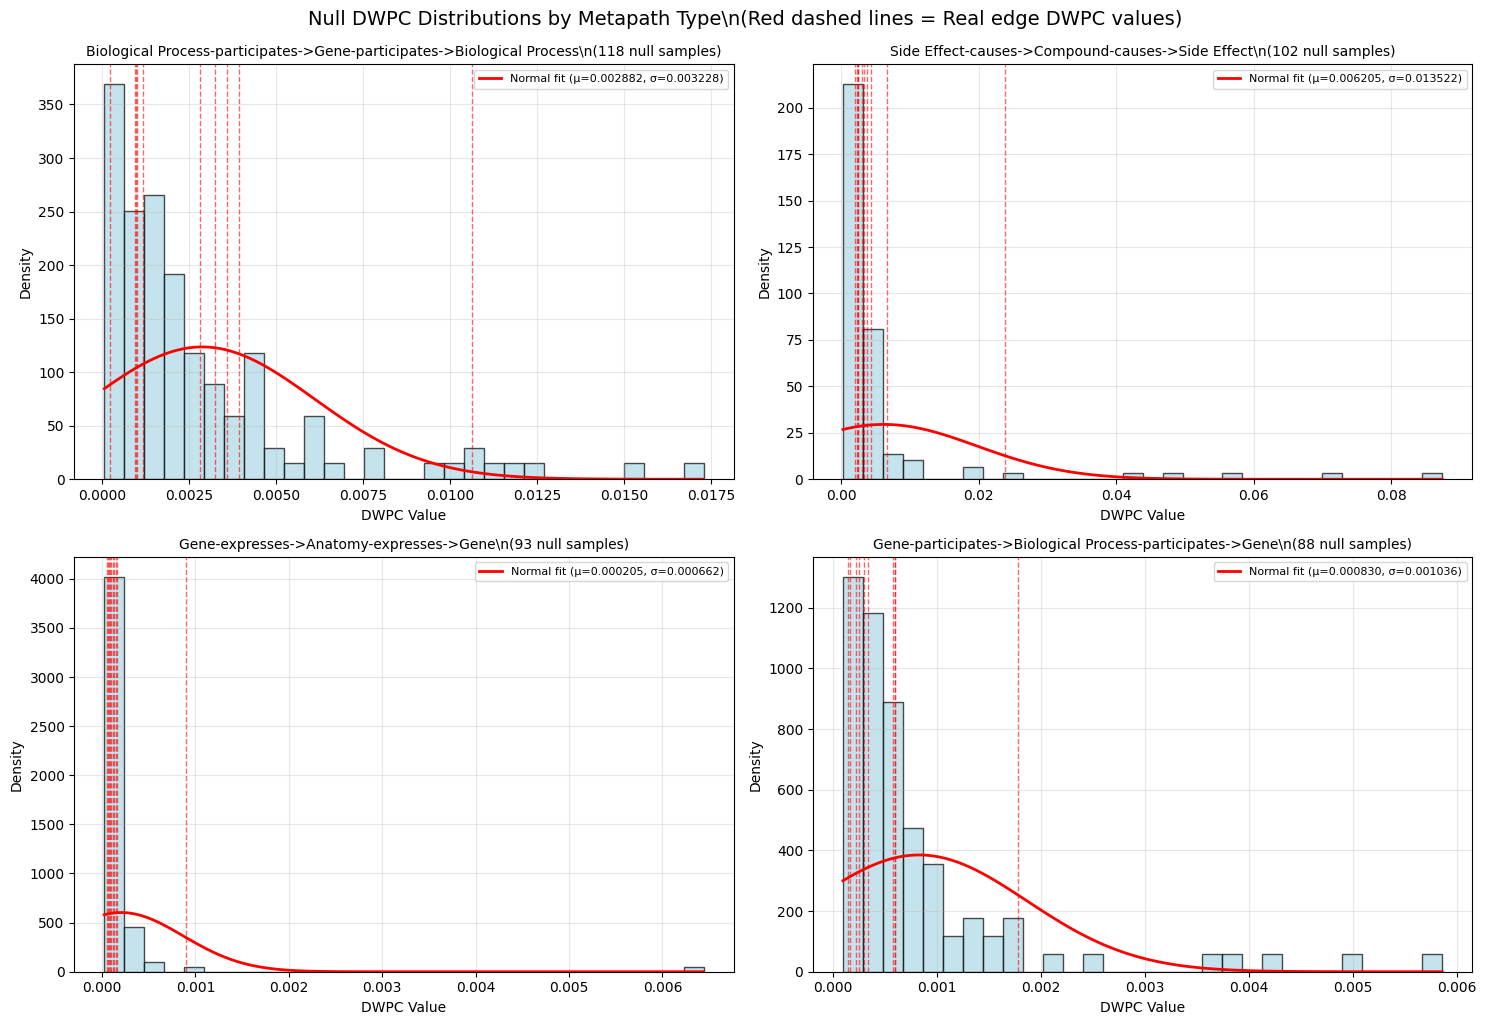

\n📊 VISUALIZATION EXPLANATION:
• Blue histograms = Null distributions from negative samples
• Red curves = Fitted normal distributions
• Red dashed lines = DWPC values of actual edges
• Actual edges that fall in the right tail are statistically significant
• Different metapaths have very different null distributions!


In [21]:
# Visualize null distributions for different metapath types
import matplotlib.pyplot as plt
import numpy as np

# Select a few metapaths with good sample sizes for visualization
metapath_subset = {k: v for k, v in null_distributions.items() if len(v) >= 20}
top_metapaths = sorted(metapath_subset.items(), key=lambda x: len(x[1]), reverse=True)[:4]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (metapath, dwpc_values) in enumerate(top_metapaths):
    ax = axes[i]
    
    # Plot histogram of null DWPC values
    ax.hist(dwpc_values, bins=30, alpha=0.7, color='lightblue', edgecolor='black', density=True)
    
    # Overlay normal distribution fit
    stats_dict = metapath_stats[metapath]
    if 'norm_mu' in stats_dict:
        mu, sigma = stats_dict['norm_mu'], stats_dict['norm_sigma']
        x = np.linspace(min(dwpc_values), max(dwpc_values), 100)
        y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        ax.plot(x, y, 'r-', linewidth=2, label=f'Normal fit (μ={mu:.6f}, σ={sigma:.6f})')
    
    # Add some positive samples for comparison
    pos_samples_this_metapath = [s for s in samples_with_dwpc if s['label'] == 1 and s['metapath'] == metapath]
    if pos_samples_this_metapath:
        pos_dwpc_values = [s['dwpc'] for s in pos_samples_this_metapath[:10]]  # First 10
        for val in pos_dwpc_values:
            ax.axvline(x=val, color='red', alpha=0.6, linestyle='--', linewidth=1)
    
    ax.set_title(f"{metapath}\\n({len(dwpc_values)} null samples)", fontsize=10)
    ax.set_xlabel('DWPC Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Null DWPC Distributions by Metapath Type\\n(Red dashed lines = Real edge DWPC values)', 
             fontsize=14, y=1.02)
plt.show()

print("\\n📊 VISUALIZATION EXPLANATION:")
print("="*50)
print("• Blue histograms = Null distributions from negative samples")
print("• Red curves = Fitted normal distributions") 
print("• Red dashed lines = DWPC values of actual edges")
print("• Actual edges that fall in the right tail are statistically significant")
print("• Different metapaths have very different null distributions!")

## 5. Practical Applications of Null Distribution Learning

### 🎯 **Key Benefits:**

1. **Statistical Significance Testing**: Test whether real edges have significantly higher DWPC values than expected by chance
2. **Feature Normalization**: Normalize DWPC features by their metapath-specific null distributions (z-score normalization)
3. **Drug Discovery**: Identify drug-disease pairs with unusually strong connectivity patterns
4. **Network Validation**: Validate that known biological relationships are statistically enriched
5. **Hypothesis Generation**: Find unexpected high-DWPC paths that warrant experimental validation

### 🔬 **Applications in Practice:**

- **Drug Repurposing**: Find compounds with significant DWPC to diseases via novel metapaths
- **Biomarker Discovery**: Identify gene-disease connections that exceed null expectations  
- **Pathway Analysis**: Discover enriched biological process connections
- **Clinical Translation**: Prioritize molecular relationships for experimental follow-up

### 📊 **Advantages over Traditional Approaches:**

- **Data-Driven**: No parametric assumptions about DWPC distributions
- **Topology-Aware**: Accounts for network structure and degree effects
- **Metapath-Specific**: Each relationship type has its own appropriate baseline
- **Scalable**: Can be computed efficiently for large networks